In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import emojis

pd.set_option('display.max_rows', None)

In [2]:
with open(r"C:\Users\aditya.shukla\Downloads\WhatsApp Chat 2.txt", 'r', encoding = 'utf-8') as f:
    content = f.readlines()

In [3]:
ppl = defaultdict(list)
 
for line in content:
    try:
        if re.match('\d{2}/\d{2}/\d{2}, \d{2}:\d{2} - (Person 1|Person 2)', line):
            parts = line.split(' - ', 1)
            timestamp = parts[0]
            person = parts[1].split(': ')[0]
            text = parts[1].split(': ')[1]
            ppl[person].append((timestamp, text))
    except:
        print(line)
        pass

In [5]:
data = []

# Loop over each person and their messages
for person, messages in ppl.items():
    # Loop over each message and add it to the data list
    for message in messages:
        timestamp = message[0]
        text = message[1].replace('\n', '')
        data.append({'Timestamp': timestamp, 'Person': person, 'Message': text})
        
df = pd.DataFrame(data)

In [6]:
message_types = {
    0: 'greeting',
    1: 'question',
#     2: 'statement',
    2: 'other',
    3: 'funny',
    4: 'exclaimatory',
    5: 'emotional', 
    6: 'media'
}

In [7]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
#     tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)

In [8]:
x = []
y = []

message_type_list = []
message_type_name_list = []

for message in df.Message:
    x.append(preprocess_text(message))
    message_type = None
    if '?' in message.lower() or 'why' in message.lower() or 'what' in message.lower():
        message_type = 1 #question
    elif '!' in message or 'wow' in message.lower() or 'damn' in message.lower() or 'dayum' in message.lower() or 'fuck' in message.lower() or 'waah' in message.lower():
        message_type = 4 #exclaimatory
    elif '😂' in message or '🤣' in message or '😆' in message or 'haha' in message.lower() or 'lmao' in message.lower():
        message_type = 3 #funny
    elif 'like' in message.lower() or 'love' in message.lower() or 'hate' in message.lower() or 'hope' in message.lower() or 'wish' in message.lower() or 'feel' in message.lower() or 'believe' in message.lower() or 'think' in message.lower() or 'soch' in message.lower() or 'jhappi' in message.lower() or 'hug' in message.lower() or '🫂' in message.lower() or '💙' in message.lower():
        message_type = 5 #emotional
    elif 'media omitted' in message.lower() or 'https://' in message.lower():
        message_type = 6 #media
    elif 'goodmorning' in message.lower() or 'goodnight' in message.lower() or 'aye' in message.lower() or 'hey' in message.lower() or 'hi' in message.lower():
        message_type = '0'
    elif message_type is None:
        message_type = 2 #other
    y.append(message_type)
    
    message_type_list.append(message_type)
    message_type_name_list.append(message_types[int(message_type)])

df['Message Type'] = message_type_list
df['Message Type Name'] = message_type_name_list
df['Date'] = df.Timestamp.str.split(', ').str[0]
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%y')
df['Day'] = df.Date.dt.day_name()
df['Hour'] = df.Timestamp.str.split(', ').str[1].str.split(':').str[0]
df['Minute'] = df.Timestamp.str.split(', ').str[1].str.split(':').str[1]
df = df.sort_values(by = ['Date', 'Hour', 'Minute'], ascending = True).reset_index()


In [10]:
df['Message Type Name'].value_counts()

other           15598
greeting         2640
question         2516
funny            1506
emotional        1465
media             399
exclaimatory      190
Name: Message Type Name, dtype: int64

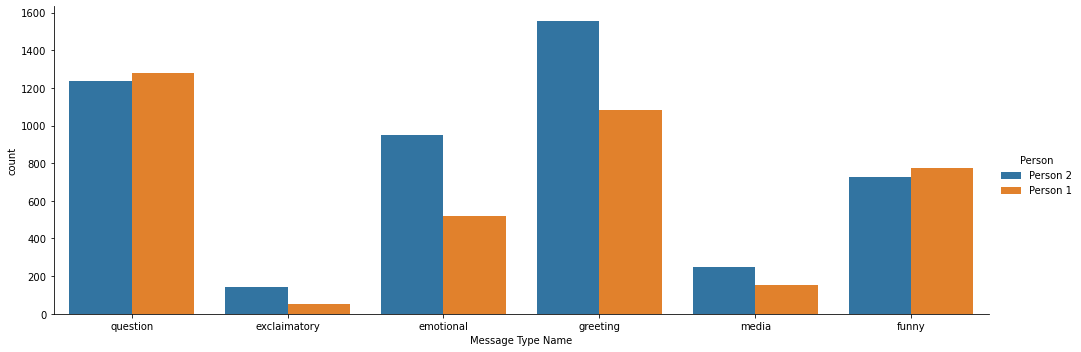

In [11]:
df_filtered = df[df['Message Type Name'] != 'other']
sns.catplot(kind = 'count', x = 'Message Type Name', hue = 'Person', data = df_filtered, palette='tab10', height=5, aspect=14/5)

plt.show()

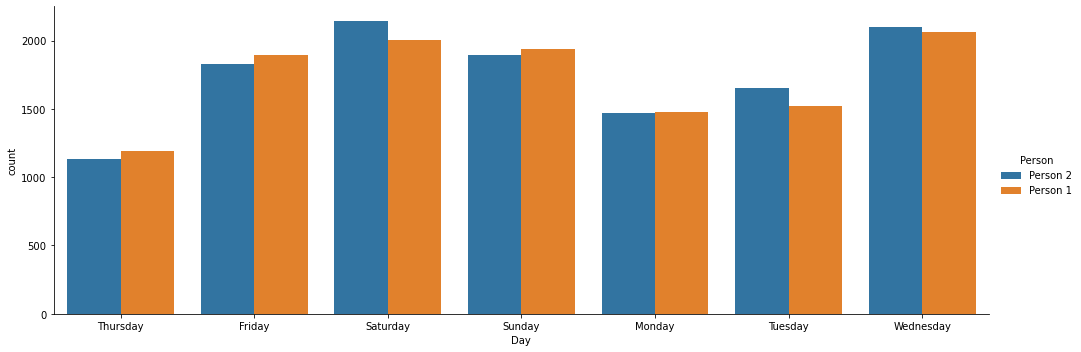

In [12]:
df_filtered = df[df['Message Type Name'] != 'other']
sns.catplot(kind = 'count', x = 'Day', hue = 'Person', data = df, palette='tab10', height=5, aspect=14/5)
plt.show()

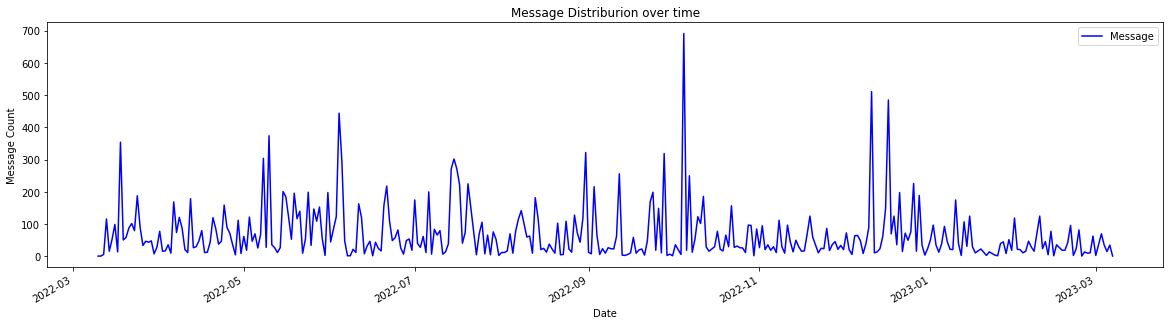

In [13]:
grouped = df.groupby('Date')['Message'].count().reset_index()

ax = grouped.plot(x='Date', y='Message', kind='line', figsize=(20, 5), color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Message Count')
ax.set_title('Message Distriburion over time')

plt.show()

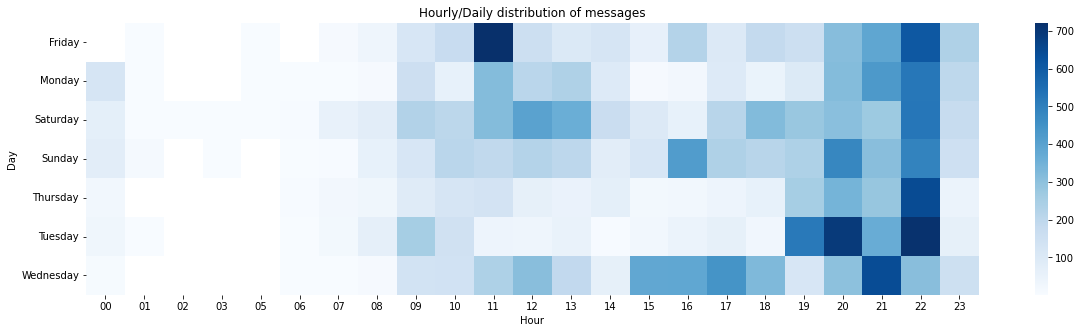

In [14]:
grouped = df.groupby(['Day', 'Hour'])['Message'].count().reset_index()
pivoted = grouped.pivot_table(index='Day', columns='Hour', values='Message')
pivoted

plt.figure(figsize=(20,5))
plt.title('Hourly/Daily distribution of messages')
sns.heatmap(pivoted,cmap='Blues')
plt.show()

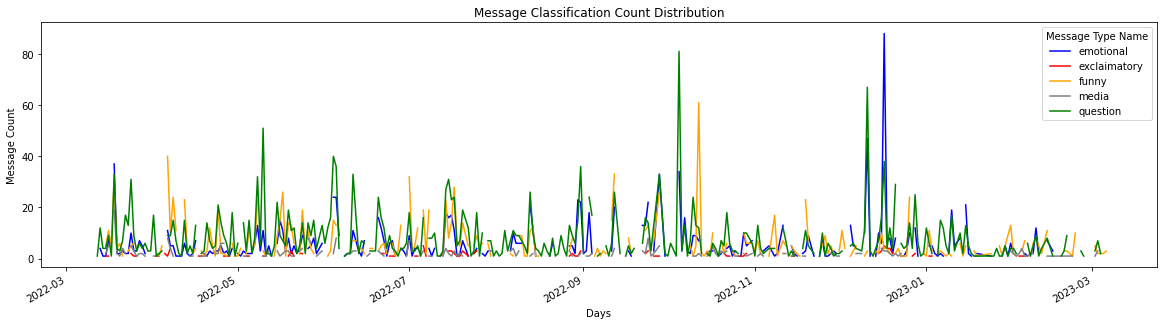

In [15]:
grouped = df[~df['Message Type Name'].isin(['other', 'greeting'])].groupby(['Date', 'Message Type Name'])['Message'].count().reset_index()
pivoted = grouped.pivot_table(index='Date', columns='Message Type Name', values='Message')

colors = ['blue', 'red', 'orange', 'grey', 'green']
fig, ax = plt.subplots(figsize=(20, 5))
pivoted.plot(ax=ax, color=colors)
plt.xlabel('Days')
plt.ylabel('Message Count')
plt.title('Message Classification Count Distribution')

plt.show()

In [16]:
X = df.Message.apply(preprocess_text)
y = df['Message Type'].astype(int)

In [17]:
vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

x = vectorizer.fit_transform(X)
x

<24314x9079 sparse matrix of type '<class 'numpy.int64'>'
	with 63665 stored elements in Compressed Sparse Row format>

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.8, random_state = 101)

In [22]:
clf = MultinomialNB()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')

print(f'Naive Bayes Accuracy Score: {round(accuracy, 2)}\nF1 Score: {round(f1, 2)}\n\nConfusion Matrix: \n{cm}')

Naive Bayes Accuracy Score: 0.73
F1 Score: 0.65

Confusion Matrix: 
[[  643     9  1456     1     0     6     0]
 [   63    74  1761     0     0   122     1]
 [   53    47 12353    11     0     4     0]
 [   34     5  1114     9     0    37     0]
 [    5    28   111     0     1     5     0]
 [   11    43   357     0     0   764     0]
 [    1    25     2     0     0     0   296]]


In [27]:
#using randomforest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000, random_state=101)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')

print(f'Random Forest Accuracy Score: {round(accuracy, 2)}\nF1 Score: {round(f1, 2)}\n\nConfusion Matrix: \n{cm}')

Random Forest Accuracy Score: 0.73
F1 Score: 0.69

Confusion Matrix: 
[[ 1093    53   959     9     0     0     1]
 [  172   233  1439    31     9   128     9]
 [  305   475 11515   167     6     0     0]
 [   77    31   991    49     0    51     0]
 [    3     6    44     1    91     5     0]
 [   31   125    84     9     0   925     1]
 [    0     0     0     0     0     0   324]]


In [26]:
#using XGBoost

import xgboost as xgb

params = {
    'objective': 'multi:softmax',
    'num_class': 6,
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed':42,
    'n_estimators': 1000,
    'early_stopping_rounds': 50
}

xg_class = xgb.XGBClassifier(objective='multi:softmax', num_class=6, seed=42, n_estimators=1000, early_stopping_rounds=50, max_depth=6, base_score=0.5, learning_rate=0.01)
xg_class.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], verbose = 100)

y_pred = xg_class.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = 'weighted')

print(f'XGBoost Accuracy Score: {round(accuracy, 2)}\nF1 Score: {round(f1, 2)}\n\nConfusion Matrix: \n{cm}')

[0]	validation_0-mlogloss:1.92923	validation_1-mlogloss:1.92931
[100]	validation_0-mlogloss:1.18627	validation_1-mlogloss:1.19515
[200]	validation_0-mlogloss:0.97840	validation_1-mlogloss:0.99360
[300]	validation_0-mlogloss:0.89298	validation_1-mlogloss:0.91413
[400]	validation_0-mlogloss:0.84944	validation_1-mlogloss:0.87619
[500]	validation_0-mlogloss:0.82319	validation_1-mlogloss:0.85497
[600]	validation_0-mlogloss:0.80550	validation_1-mlogloss:0.84241
[700]	validation_0-mlogloss:0.79223	validation_1-mlogloss:0.83407
[800]	validation_0-mlogloss:0.78188	validation_1-mlogloss:0.82803
[900]	validation_0-mlogloss:0.77284	validation_1-mlogloss:0.82358
[999]	validation_0-mlogloss:0.76542	validation_1-mlogloss:0.82020
XGBoost Accuracy Score: 0.77
F1 Score: 0.69

Confusion Matrix: 
[[  954     9  1151     1     0     0     0]
 [   72    59  1701     2     5   178     4]
 [    2    13 12453     0     0     0     0]
 [   59     1  1059    24     0    56     0]
 [    2     0    82     0    59 